In [1]:
import math
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
random_stat = 123
np.random.seed(random_stat)

In [3]:
!git clone https://github.com/pjreddie/darknet.git

# Build gpu version darknet
!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

# -j <The # of cpu cores to use>. Chang 999 to fit your environment. Actually i used '-j 50'.
!cd darknet && make -j 999 -s
!cp darknet/darknet darknet_gpu

fatal: destination path 'darknet' already exists and is not an empty directory.
'sed'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'make'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'cp'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [4]:
DATA_DIR = "rsna-pneumonia"

train_dcm_dir = os.path.join(DATA_DIR, "stage_2_train_images")
test_dcm_dir = os.path.join(DATA_DIR, "stage_2_test_images")

img_dir = os.path.join(os.getcwd(), "images")  # .jpg
label_dir = os.path.join(os.getcwd(), "labels")  # .txt
metadata_dir = os.path.join(os.getcwd(), "metadata") # .txt

# YOLOv3 config file directory
cfg_dir = os.path.join(os.getcwd(), "cfg")
# YOLOv3 training checkpoints will be saved here
backup_dir = os.path.join(os.getcwd(), "backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [5]:
!ls -shtl

'ls'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [6]:
annots = pd.read_csv(os.path.join(DATA_DIR, "stage_2_train_labels.csv"))
annots.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [7]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # rsna defualt image size
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'r' means relative. 'c' means center.
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
        
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue

        target = row[5]
        # Since kaggle kernel have samll volume (5GB ?), I didn't contain files with no bbox here.
        if target == 0:
            continue
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

In [8]:
save_yolov3_data_from_rsna(train_dcm_dir, img_dir, label_dir, annots)

100%|██████████| 30227/30227 [04:27<00:00, 113.20it/s]


In [14]:
!du -sh images labels

'du'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [13]:
img_dir

'c:\\Users\\82106\\OneDrive - Microsoft 365\\문서\\가은대학\\2022\\2022 4학년 1학기\\딥노이드\\code\\images'

In [16]:
!pip3 install scipy==1.2

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\82106\\AppData\\Local\\Temp\\pip-uninstall-sf809m5b\\libansari.y7ankimnmvhzxxzwcxl6gfggyuim7yor.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.




     ---------------------------------------- 31.7/31.7 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [20]:
import scipy
scipy.__version__

'1.7.3'

In [19]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from scipy import ndimage, misc
from scipy.misc import imshow
import skimage

ImportError: cannot import name 'imshow' from 'scipy.misc' (c:\Users\82106\anaconda3\envs\tensorflow\lib\site-packages\scipy\misc\__init__.py)

TypeError: Image data of dtype object cannot be converted to float

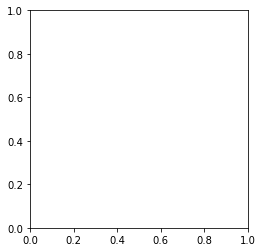

In [12]:
ex_patient_id = annots[annots.Target == 1].patientId.values[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))


mod_img = ndimage.median_filter(ex_img_path, 20)
plt.imshow(cv2.imread(mod_img))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])
